In [1]:
from ase.build import bulk
from atomistics.calculators import (
    calc_molecular_dynamics_phonons_with_lammpslib,
    evaluate_with_lammpslib,
    get_potential_by_name
)
from atomistics.workflows import (
    optimize_positions_and_volume,
    get_tasks_for_harmonic_approximation,
    analyse_results_for_harmonic_approximation,
)
from dynaphopy import Quasiparticle
import pandas
from phonopy.units import VaspToTHz
import spglib

from HelpfulFunctions import equilibriate_structure_at_finite_temperature



/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2025-11-10/lib/python3.12/site-packages/atomistics/calculators/__init__.py:63: UserWarning: calc_static_with_qe(), evaluate_with_qe() and optimize_positions_and_volume_with_qe() are not available as the import of the module named 'pwtools' failed.
  raise_warning(module_list=quantum_espresso_function, import_error=e)


In [2]:
structure_bulk = bulk("Si", cubic=True)
potential_dataframe = get_potential_by_name(
    potential_name="1988--Tersoff-J--Si-c--LAMMPS--ipr1"
)

## Base - Present example

In [3]:
task_dict = optimize_positions_and_volume(structure=structure_bulk)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
structure_ase = result_dict["structure_with_optimized_positions_and_volume"]

In [4]:
cell = (
    structure_ase.cell.array,
    structure_ase.get_scaled_positions(),
    structure_ase.numbers,
)
primitive_matrix = spglib.standardize_cell(cell=cell, to_primitive=True)[
   0
] / structure_ase.get_volume() ** (1 / 3)

task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
    structure=structure_ase,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    primitive_matrix=primitive_matrix,
    number_of_snapshots=None,
)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
phonopy_dict = analyse_results_for_harmonic_approximation(
    phonopy=phonopy_obj,
    output_dict=result_dict,
    dos_mesh=20,
    number_of_snapshots=None,
)

In [5]:
trajectory = calc_molecular_dynamics_phonons_with_lammpslib(
    structure_ase=structure_ase,
    potential_dataframe=potential_dataframe,
    force_constants=phonopy_obj.force_constants,
    phonopy_unitcell=phonopy_obj.unitcell,
    phonopy_primitive_matrix=phonopy_obj.primitive_matrix,
    phonopy_supercell_matrix=phonopy_obj.supercell_matrix,
    total_time=2,  # ps
    time_step=0.001,  # ps
    relaxation_time=5,  # ps
    silent=True,
    supercell=[2, 2, 2],
    memmap=False,
    velocity_only=True,
    temperature=600,
)

In [6]:
calculation = Quasiparticle(trajectory)
calculation.select_power_spectra_algorithm(2)  # select FFT algorithm
calculation.get_renormalized_phonon_dispersion_bands()
renormalized_force_constants = (
    calculation.get_renormalized_force_constants().get_array()
)
renormalized_force_constants

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 21.200000000000003

Q-point: 1 / 32     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-4.13530665e-06 -4.13310396e-06 -4.12861117e-06  1.60678991e+01
  1.60678991e+01  1.60678991e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.469923 THz
Position                          0.032916 THz
Area (<K>)    (Lorentzian)        0.000000 eV
Area (<K>)    (Total)             0.000000 eV
<|dQ/dt|^2>                       0.000000 eV
Occupation number                -0.500000
Fit temperature                        nan K
Base line      

array([[[[ 1.48010645e+01,  5.07266464e-04,  5.07266464e-04],
         [ 5.07266464e-04,  1.48010645e+01,  5.07266464e-04],
         [ 5.07266464e-04,  5.07266464e-04,  1.48010645e+01]],

        [[-6.14949149e-03, -5.07266464e-04, -5.07266464e-04],
         [-5.07266464e-04,  9.38806037e-03,  5.07266464e-04],
         [-5.07266464e-04,  5.07266464e-04,  9.38806037e-03]],

        [[ 9.38806037e-03, -5.07266464e-04,  5.07266464e-04],
         [-5.07266464e-04, -6.14949149e-03, -5.07266464e-04],
         [ 5.07266464e-04, -5.07266464e-04,  9.38806037e-03]],

        ...,

        [[-5.77682150e-03,  1.30069291e-03, -2.33788274e-03],
         [ 1.30069291e-03,  4.57056684e-03,  1.22313564e-02],
         [-2.33788274e-03,  1.22313564e-02,  6.22817675e-03]],

        [[ 4.57056684e-03,  1.30069291e-03,  1.22313564e-02],
         [ 1.30069291e-03, -5.77682150e-03, -2.33788274e-03],
         [ 1.22313564e-02, -2.33788274e-03,  6.22817675e-03]],

        [[ 6.29176831e-03,  2.05255300e-05,  4

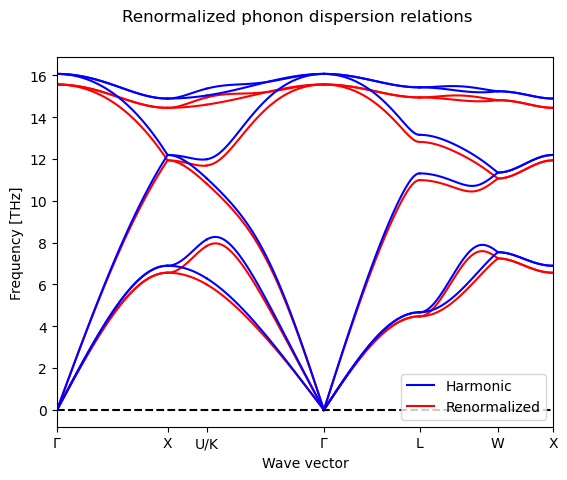

In [7]:
calculation.plot_renormalized_phonon_dispersion_bands()

In [8]:
structure_ase.cell

Cell([5.43197901764179, 5.43197901764179, 5.43197901764179])

## Altered Primitive Matrix

In [9]:
cell = (
    structure_ase.cell.array,
    structure_ase.get_scaled_positions(),
    structure_ase.numbers,
)

import numpy as np
primitive_matrix = np.eye(3)
# primitive_matrix = spglib.standardize_cell(cell=cell, to_primitive=True)[
#    0
# ] / structure_ase.get_volume() ** (1 / 3)

task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
    structure=structure_ase,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    primitive_matrix=primitive_matrix,
    number_of_snapshots=None,
)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
phonopy_dict = analyse_results_for_harmonic_approximation(
    phonopy=phonopy_obj,
    output_dict=result_dict,
    dos_mesh=20,
    number_of_snapshots=None,
)

In [10]:
trajectory = calc_molecular_dynamics_phonons_with_lammpslib(
    structure_ase=structure_ase,
    potential_dataframe=potential_dataframe,
    force_constants=phonopy_obj.force_constants,
    phonopy_unitcell=phonopy_obj.unitcell,
    phonopy_primitive_matrix=phonopy_obj.primitive_matrix,
    phonopy_supercell_matrix=phonopy_obj.supercell_matrix,
    total_time=2,  # ps
    time_step=0.001,  # ps
    relaxation_time=5,  # ps
    silent=True,
    supercell=[2, 2, 2],
    memmap=False,
    velocity_only=True,
    temperature=600,
)

In [11]:
calculation = Quasiparticle(trajectory)
calculation.select_power_spectra_algorithm(2)  # select FFT algorithm
calculation.get_renormalized_phonon_dispersion_bands()
renormalized_force_constants = (
    calculation.get_renormalized_force_constants().get_array()
)
renormalized_force_constants

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 21.200000000000003

Q-point: 1 / 8     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-4.13122059e-06 -4.12974343e-06 -4.12620573e-06  6.89533567e+00
  6.89533567e+00  6.89533567e+00  6.89533567e+00  6.89533567e+00
  6.89533567e+00  1.21917904e+01  1.21917904e+01  1.21917904e+01
  1.21917904e+01  1.21917904e+01  1.21917904e+01  1.48909552e+01
  1.48909552e+01  1.48909552e+01  1.48909552e+01  1.48909552e+01
  1.48909552e+01  1.60678991e+01  1.60678991e+01  1.60678991e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.470238 T

array([[[[ 1.47988835e+01,  2.04246101e-16,  3.09856003e-16],
         [ 2.33255594e-16,  1.47988835e+01, -1.42336744e-16],
         [ 3.17742429e-16, -1.08775042e-16,  1.47988835e+01]],

        [[-5.18008438e-03, -5.33121254e-16,  2.74769251e-16],
         [-5.72188614e-16,  6.35427641e-03,  4.48611799e-15],
         [ 2.88956723e-16,  4.48009423e-15,  6.35427641e-03]],

        [[ 6.35427641e-03,  2.01346940e-16,  1.66664705e-16],
         [ 2.26347629e-16, -5.18008438e-03, -1.37253129e-15],
         [ 2.28112907e-16, -1.36941995e-15,  6.35427641e-03]],

        ...,

        [[-7.43492173e-03,  1.99955110e-03, -1.99955110e-03],
         [ 1.99955110e-03,  7.74693689e-03,  1.22905892e-02],
         [-1.99955110e-03,  1.22905892e-02,  7.74693689e-03]],

        [[ 7.74693689e-03,  1.99955110e-03,  1.22905892e-02],
         [ 1.99955110e-03, -7.43492173e-03, -1.99955110e-03],
         [ 1.22905892e-02, -1.99955110e-03,  7.74693689e-03]],

        [[ 4.40730015e-03,  2.58476906e-03,  3

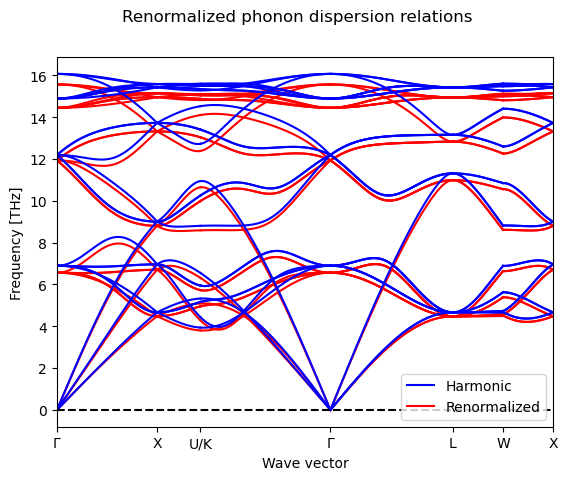

In [12]:
calculation.plot_renormalized_phonon_dispersion_bands()

## With Vacancy - ~12%

In [13]:
import ase
def create_vacancy(Structure:ase.Atoms,
                  index:int=0)->ase.Atoms:
    del Structure[index]
    return Structure

In [14]:
structure_vacancy = create_vacancy(structure_bulk)

task_dict = optimize_positions_and_volume(structure=structure_vacancy)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
structure_ase_vacancy = result_dict["structure_with_optimized_positions_and_volume"]

In [15]:
cell = (
    structure_ase_vacancy.cell.array,
    structure_ase_vacancy.get_scaled_positions(),
    structure_ase_vacancy.numbers,
)
primitive_matrix = spglib.standardize_cell(cell=cell, to_primitive=True)[
    0
] / structure_ase_vacancy.get_volume() ** (1 / 3)


task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
    structure=structure_ase_vacancy,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    primitive_matrix=primitive_matrix,
    number_of_snapshots=None,
)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
phonopy_dict = analyse_results_for_harmonic_approximation(
    phonopy=phonopy_obj,
    output_dict=result_dict,
    dos_mesh=20,
    number_of_snapshots=None,
)

In [16]:
trajectory = calc_molecular_dynamics_phonons_with_lammpslib(
    structure_ase=structure_ase_vacancy,
    potential_dataframe=potential_dataframe,
    force_constants=phonopy_obj.force_constants,
    phonopy_unitcell=phonopy_obj.unitcell,
    phonopy_primitive_matrix=phonopy_obj.primitive_matrix,
    phonopy_supercell_matrix=phonopy_obj.supercell_matrix,
    total_time=2,  # ps
    time_step=0.001,  # ps
    relaxation_time=5,  # ps
    silent=True,
    supercell=[2, 2, 2],
    memmap=False,
    velocity_only=True,
    temperature=600,
)

In [17]:
calculation = Quasiparticle(trajectory)
calculation.select_power_spectra_algorithm(2)  # select FFT algorithm
calculation.get_renormalized_phonon_dispersion_bands()
renormalized_force_constants = (
    calculation.get_renormalized_force_constants().get_array()
)
renormalized_force_constants

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 21.400000000000002

Q-point: 1 / 8     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-3.63711978e-04 -3.63711835e-04 -3.63711746e-04  5.24331665e+00
  5.24331665e+00  5.24331665e+00  6.44993422e+00  6.44993422e+00
  6.44993422e+00  7.61398888e+00  1.18901824e+01  1.18901824e+01
  1.26631241e+01  1.26631241e+01  1.26631241e+01  1.50172267e+01
  1.50172267e+01  1.50172267e+01  1.61885967e+01  1.61885967e+01
  1.61885967e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.544913 THz
Position                          5.028672 TH

array([[[[ 1.12673443e+01, -3.39923596e+00, -3.39923596e+00],
         [-3.39923596e+00,  1.12673443e+01, -3.39923596e+00],
         [-3.39923596e+00, -3.39923596e+00,  1.12673443e+01]],

        [[ 4.31010289e-02, -1.88431791e-02, -1.88431791e-02],
         [-1.88431791e-02,  1.56161612e-02,  2.71810727e-03],
         [-1.88431791e-02,  2.71810727e-03,  1.56161612e-02]],

        [[ 1.56161612e-02, -1.88431791e-02,  2.71810727e-03],
         [-1.88431791e-02,  4.31010289e-02, -1.88431791e-02],
         [ 2.71810727e-03, -1.88431791e-02,  1.56161612e-02]],

        ...,

        [[-6.75684612e-03,  4.05749268e-03,  2.35019348e-03],
         [ 4.05749268e-03, -1.49150240e-02,  1.02468680e-03],
         [-2.35019348e-03, -1.02468680e-03,  1.82620658e-02]],

        [[-1.49150240e-02,  4.05749268e-03,  1.02468680e-03],
         [ 4.05749268e-03, -6.75684612e-03,  2.35019348e-03],
         [-1.02468680e-03, -2.35019348e-03,  1.82620658e-02]],

        [[-1.83014037e-02,  1.83636634e-03, -5

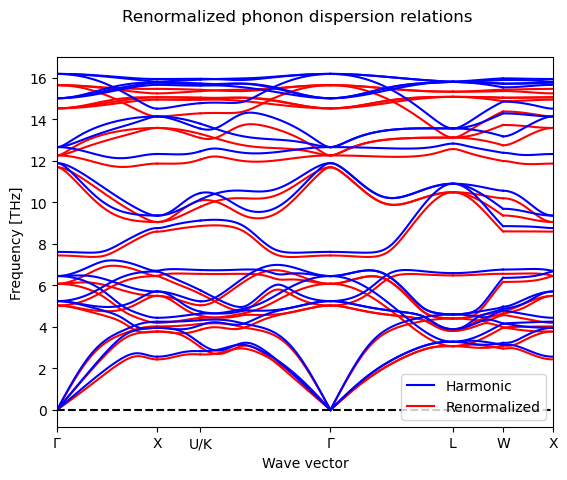

In [18]:
calculation.plot_renormalized_phonon_dispersion_bands()

## Finite Temperature Equilibration

In [19]:
import numpy as np
equilibriated_structure = equilibriate_structure_at_finite_temperature(
        structure=structure_bulk,
        potential=potential_dataframe['Name'], 
        temperature=600, 
        seed=4535,
        cell_scale_value=1
    )

In [20]:
equilibriated_structure_vacancy = equilibriate_structure_at_finite_temperature(
        structure=create_vacancy(structure_bulk),
        potential=potential_dataframe['Name'], 
        temperature=600, 
        seed=4535,
        cell_scale_value=1
    )

In [21]:
cell = (
    equilibriated_structure.cell.array,
    equilibriated_structure.get_scaled_positions(),
    equilibriated_structure.numbers,
)
primitive_matrix = spglib.standardize_cell(cell=cell, to_primitive=True)[
    0
] / equilibriated_structure.get_volume() ** (1 / 3)
task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
    structure=equilibriated_structure,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    primitive_matrix=primitive_matrix,
    number_of_snapshots=None,
)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
phonopy_dict = analyse_results_for_harmonic_approximation(
    phonopy=phonopy_obj,
    output_dict=result_dict,
    dos_mesh=20,
    number_of_snapshots=None,
)

In [22]:
trajectory = calc_molecular_dynamics_phonons_with_lammpslib(
    structure_ase=equilibriated_structure,
    potential_dataframe=potential_dataframe,
    force_constants=phonopy_obj.force_constants,
    phonopy_unitcell=phonopy_obj.unitcell,
    phonopy_primitive_matrix=phonopy_obj.primitive_matrix,
    phonopy_supercell_matrix=phonopy_obj.supercell_matrix,
    total_time=2,  # ps
    time_step=0.001,  # ps
    relaxation_time=5,  # ps
    silent=True,
    supercell=[2, 2, 2],
    memmap=False,
    velocity_only=True,
    temperature=600,
)

In [23]:
calculation = Quasiparticle(trajectory)
calculation.select_power_spectra_algorithm(2)  # select FFT algorithm
calculation.get_renormalized_phonon_dispersion_bands()
renormalized_force_constants = (
    calculation.get_renormalized_force_constants().get_array()
)
renormalized_force_constants

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 24.400000000000002

Q-point: 1 / 8     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-2.88487364e-04 -2.15755144e-04 -1.80671160e-04  4.00792600e+00
  4.68212947e+00  5.18963664e+00  6.25059021e+00  6.33359576e+00
  6.49783735e+00  7.33306507e+00  1.07700957e+01  1.15678602e+01
  1.18370092e+01  1.22459968e+01  1.25325899e+01  1.38865137e+01
  1.46132638e+01  1.54149530e+01  1.62477462e+01  1.66614235e+01
  1.84903791e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.470360 THz
Position                          0.032959 TH

array([[[[ 1.10463327e+01, -4.24231844e+00, -4.02042931e+00],
         [-4.24231844e+00,  1.18358857e+01, -3.19847472e+00],
         [-4.02042931e+00, -3.19847472e+00,  1.17290184e+01]],

        [[ 2.39049043e-03,  7.09720172e-02,  3.28475502e-02],
         [ 7.09720172e-02, -1.32985450e-01,  1.29828528e-01],
         [ 3.28475502e-02,  1.29828528e-01, -2.16882305e-02]],

        [[-3.71748097e-02,  8.69715042e-02, -7.47758661e-03],
         [ 8.69715042e-02,  2.37830692e-01, -2.62230494e-01],
         [-7.47758661e-03, -2.62230494e-01,  2.10584072e-01]],

        ...,

        [[ 5.61682360e-02, -3.77867957e-02,  5.09384908e-02],
         [-1.35328316e-01,  4.48535034e-02, -1.05466654e-02],
         [ 7.26003229e-02, -1.21825317e-01, -3.74957687e-02]],

        [[-2.77553663e-02, -2.39952254e-02, -2.29046683e-02],
         [ 2.48907988e-02, -1.42765385e-02, -3.46758942e-02],
         [-5.17152695e-02,  1.26476491e-01, -6.01188157e-02]],

        [[ 1.75148143e-04,  8.73450493e-03,  8

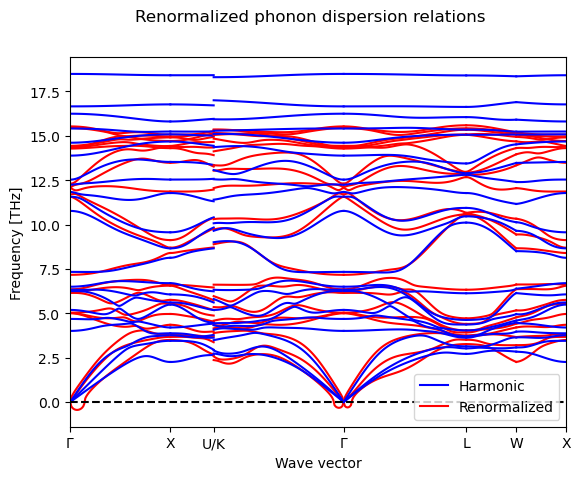

In [24]:
calculation.plot_renormalized_phonon_dispersion_bands()

In [25]:
cell = (
    equilibriated_structure_vacancy.cell.array,
    equilibriated_structure_vacancy.get_scaled_positions(),
    equilibriated_structure_vacancy.numbers,
)
primitive_matrix = spglib.standardize_cell(cell=cell, to_primitive=True)[
    0
] / equilibriated_structure_vacancy.get_volume() ** (1 / 3)

task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
    structure=equilibriated_structure_vacancy,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    primitive_matrix=primitive_matrix,
    number_of_snapshots=None,
)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
phonopy_dict = analyse_results_for_harmonic_approximation(
    phonopy=phonopy_obj,
    output_dict=result_dict,
    dos_mesh=20,
    number_of_snapshots=None,
)

In [26]:
trajectory = calc_molecular_dynamics_phonons_with_lammpslib(
    structure_ase=equilibriated_structure_vacancy,
    potential_dataframe=potential_dataframe,
    force_constants=phonopy_obj.force_constants,
    phonopy_unitcell=phonopy_obj.unitcell,
    phonopy_primitive_matrix=phonopy_obj.primitive_matrix,
    phonopy_supercell_matrix=phonopy_obj.supercell_matrix,
    total_time=2,  # ps
    time_step=0.001,  # ps
    relaxation_time=5,  # ps
    silent=True,
    supercell=[2, 2, 2],
    memmap=False,
    velocity_only=True,
    temperature=600,
)

In [27]:
calculation = Quasiparticle(trajectory)
calculation.select_power_spectra_algorithm(2)  # select FFT algorithm
calculation.get_renormalized_phonon_dispersion_bands()
renormalized_force_constants = (
    calculation.get_renormalized_force_constants().get_array()
)
renormalized_force_constants

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 24.200000000000003

Q-point: 1 / 8     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-3.73596427e-04 -2.69867954e-04 -1.80223323e-04  3.44491564e+00
  3.68351263e+00  3.90269704e+00  5.14450415e+00  5.74343550e+00
  5.93110969e+00  7.56861445e+00  8.32685085e+00  1.05620679e+01
  1.24888559e+01  1.37854784e+01  1.42568271e+01  1.55416407e+01
  1.70100979e+01  1.82042014e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.469214 THz
Position                          0.032713 THz
Area (<K>)    (Lorentzian)        0.047332 eV
A

array([[[[ 1.34580443e+01,  3.71672641e+00,  3.79057811e+00],
         [ 3.71672641e+00,  1.21168168e+01, -4.93460558e+00],
         [ 3.79057811e+00, -4.93460558e+00,  1.13284964e+01]],

        [[ 2.54196289e-01, -4.07109281e-01,  6.38230076e-01],
         [-4.07109281e-01,  7.00604309e-01, -2.80573870e-01],
         [ 6.38230076e-01, -2.80573870e-01,  4.00113470e-01]],

        [[-6.33108532e-03,  5.34719198e-01,  1.88639281e-01],
         [ 5.34719198e-01, -7.13617835e-01, -1.16626487e-01],
         [ 1.88639281e-01, -1.16626487e-01, -3.80211365e-01]],

        ...,

        [[-2.52379324e+00,  2.33422000e+00, -2.80077405e+00],
         [ 1.17504264e+00, -3.65829905e+00,  2.42417498e+00],
         [-1.89195511e+00,  2.54888799e+00, -3.42279825e+00]],

        [[ 2.33641897e-01, -6.41049294e-03,  4.20532229e-01],
         [ 4.93904857e-01, -3.75306865e-02, -4.17103958e-01],
         [ 7.21187807e-01, -3.10191867e-01,  1.04515366e-01]],

        [[-4.49755178e-01,  1.35955961e-01, -4

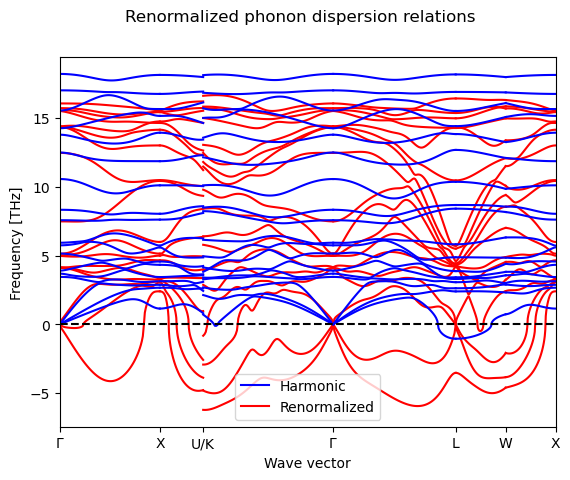

In [28]:
calculation.plot_renormalized_phonon_dispersion_bands()